# **Task 5 Morphological Image Processing**

In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import urllib
import imutils
from skimage import io

In [2]:
def plot_images(images, titles, rows, cols , info = -1 , color = cv2.COLOR_BGR2GRAY, w = 20 , h = 10):
    fig = plt.figure(figsize=(w, h))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        if info != -1:
            ax.text(0.5, 0.5, info[i], fontsize=10, color='black', ha='left', va='top')
        ax.imshow(X=images[i],  cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

In [3]:
def img_reconstruct(img, marker, kernel_size):
    mask = img
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    recon1 = marker.copy()
    recon1_old = np.zeros(recon1.shape, dtype=np.uint8)
    count = 0
    his = []
    while np.sum(np.sum(recon1 - recon1_old)) != 0:
        count += 1
        recon1_old = recon1.copy()
        recon1 = cv2.dilate(recon1, se)
        recon1 = recon1 & mask
        his.append(recon1.copy())
    print('Iteration: ', count)
    return recon1 , his

In [4]:
def show_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

## **Import Image**

In [5]:
req = urllib.request.urlopen('https://github.com/AthimetA/FRA321/blob/main/IMGpro/img/Task5.png?raw=true')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgOri = img.copy()

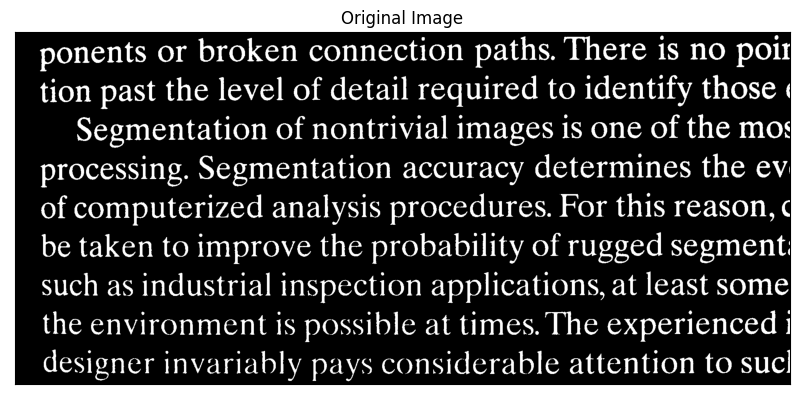

In [6]:
show_image(img, 'Original Image')

## **Clear Border Charater**

โดยเริ่มแรกจะทำการลบตัวอักษรที่เป็นขอบของรูปภาพออกไปก่อน

### **Create Border Image**

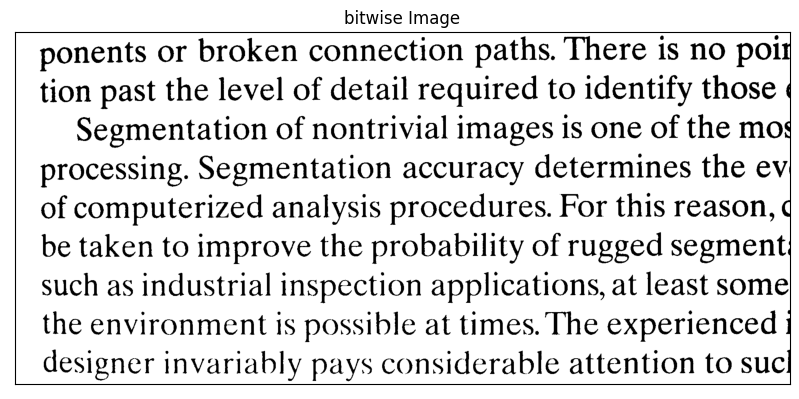

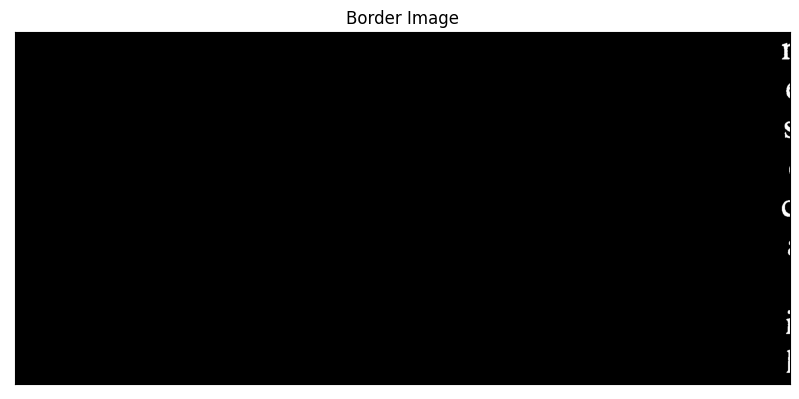

In [7]:
des = cv2.bitwise_not(img)
show_image(des, 'bitwise Image')

contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv2.drawContours(des,[cnt],0,255,-1)

img_border = cv2.bitwise_not(des)
show_image(img_border, 'Border Image')

### **Subtracting Image**

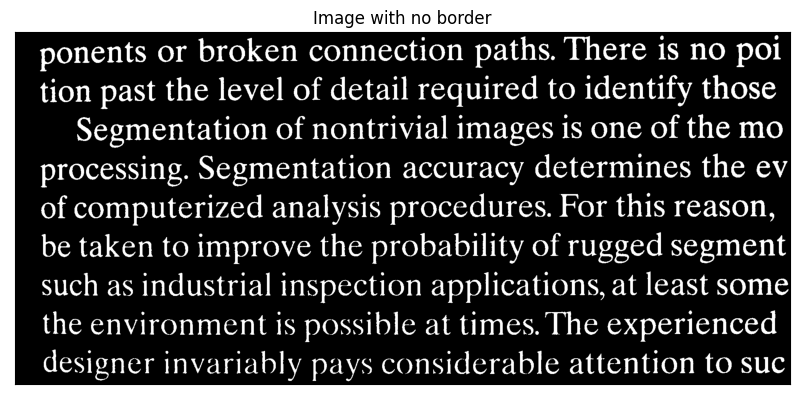

In [8]:
imgnb = cv2.bitwise_and(img, img, mask=des)
show_image(imgnb, 'Image with no border')

เมื่อทำการลบตัวอักษรที่ขอบของรูปภาพแล้วจะเหลือเฉพาะตัวอักษรเต็มตัวที่อยู่ในรูปภาพ

## **Morphological for Connecting a circle in the image**

เมื่อสังเกตจากภาพจะเห็นได้ว่าตัวอักษรหลายตัวในรูปภาพ (โดยเฉพาะตัว O ที่เราต้องการหา) นั้นมีการเชื่อมต่อกันไม่ครบทั้งหมด จึงทำการเชื่อมต่อตัวอักษรที่เป็นเส้นตรงด้วยการใช้ Morphological Opening

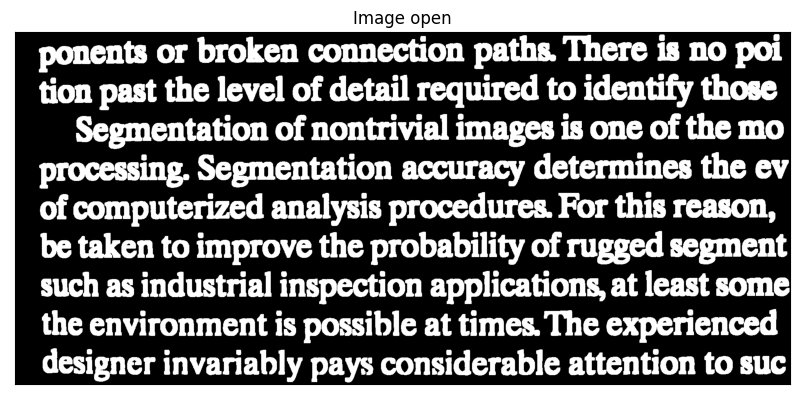

In [9]:
kernel_size = 7
se = cv2.getStructuringElement(shape =cv2.MORPH_RECT, ksize=(kernel_size, kernel_size))
img_open = cv2.morphologyEx(imgnb, cv2.MORPH_DILATE, se)
show_image(img_open, 'Image open')

In [10]:
img = img_open.copy()

หลังจากที่ทำการลองปรับจูนค่า kernel แล้วพบว่า kernel ที่ใช้งานได้ดีที่สุดคือ kernel ขนาด 7x7 โดยผลลัพท์ที่ได้จะได้ภาพที่ตัวอักษรเชื่อมต่อกันเรียบร้อยแล้ว

## **Fill a hole(Circle) in image**

จากนั้นจะทำการถมจุดที่เป็นรูกลมๆ ในรูปภาพโดยใช้ Contour ทรงกลมที่ปรับจูนให้เหมาะสมกับรูปภาพ

In [11]:
def find_circle_contour(c):
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.01 * peri, True)
	return not len(approx) == 4

In [12]:
# find contours in the image and initialize the mask that will be
# used to find circle contours
cnts = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
mask = np.ones(img.shape[:2], dtype="uint8") * 255

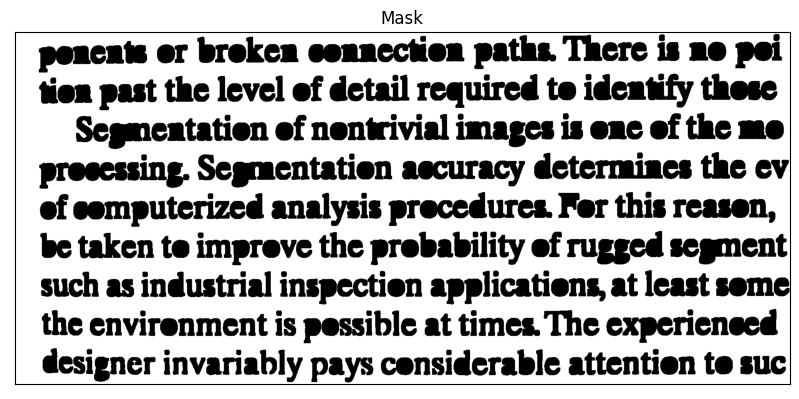

In [13]:
# loop over the contours
for c in cnts:
	# if the contour is circle, draw it on the mask
	if find_circle_contour(c):
		cv2.drawContours(mask, [c], -1, 0, -1)
show_image(mask, 'Mask')

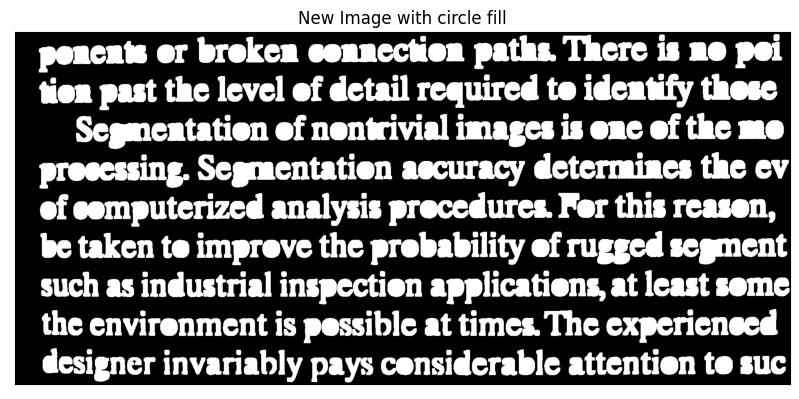

In [14]:
img = np.invert(mask)
show_image(img, 'New Image with circle fill')

ผลลัพท์ที่ได้จะเป็นรูปภาพที่ถมรูกลมๆ ให้เรียบร้อยแล้ว

## **Morphological for finding a hole(Circle) Location**

จะทำการ Morphological ที่รูปภาพที่ถมรูแล้วด้วย Kernel ทรงกลมขนาด 35x35 (หายใช้มากกว่านี้ตัว O จะหายไป) โดยตัวอักษรที่ไม่มีลักษณะคล้ายทรงกลมจะถูกลบออกไป

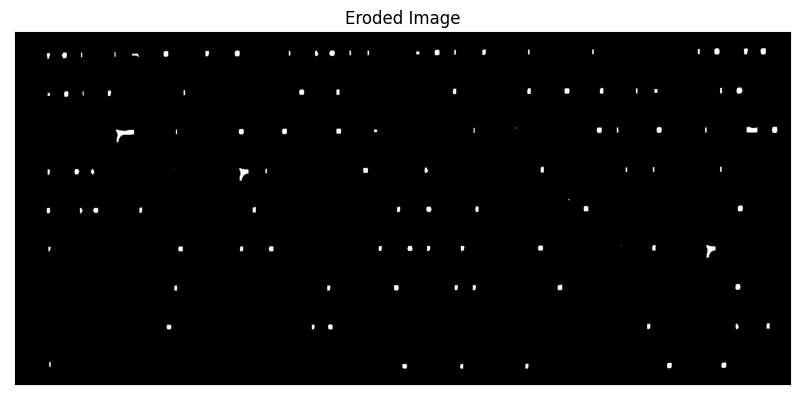

In [15]:
kernel_size = 35 # Note: kernel_size more than 35 will cause the missing of O
se = cv2.getStructuringElement(shape =cv2.MORPH_ELLIPSE, ksize=(kernel_size, kernel_size))
imgM2_erode = cv2.erode(img.copy(), se)
show_image(imgM2_erode, 'Eroded Image')

Iteration:  29


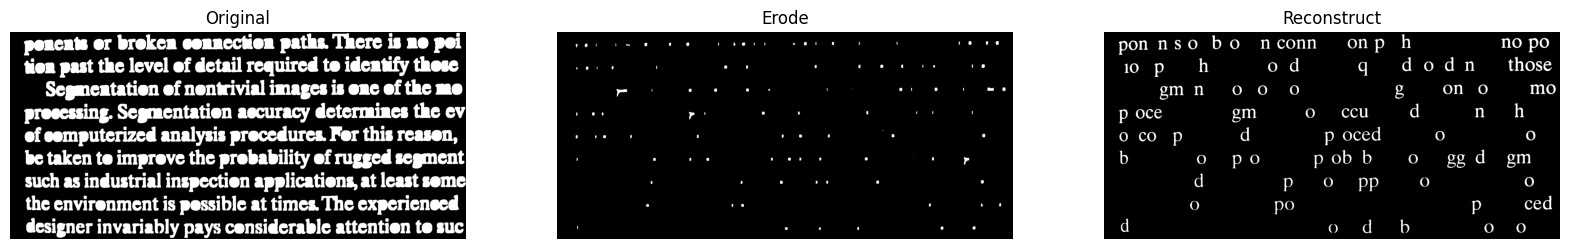

In [16]:
imgM2_reconstruct , his = img_reconstruct(imgnb, imgM2_erode, 12)

titles = ['Original', 'Erode', 'Reconstruct']
imgs = [img, imgM2_erode, imgM2_reconstruct]
plot_images(imgs, titles, 1, 3)

ผลลัทพ์ที่ได้ยังไม่ค่อยดีมากนักเพราะตัวอักษรที่ไม่มีลักษณะคล้ายทรงกลมยังอยู่บนรูปภาพ จึงจะทำการ Morphological อีกครั้ง

## **Morphological for remove Non-O charater**

โดยการทำ Morphological จะนำรูปในขั้นตอนที่แล้วที่ยังไม่ได้ Reconstruction มาทำ Morphological opening ด้วย kernel ทรงกลมขนาด 9x9 เพื่อลบส่วนของตัวอักษรที่ไม่มีลักษณะคล้ายทรงกลมออกไป

### **First Iteration**

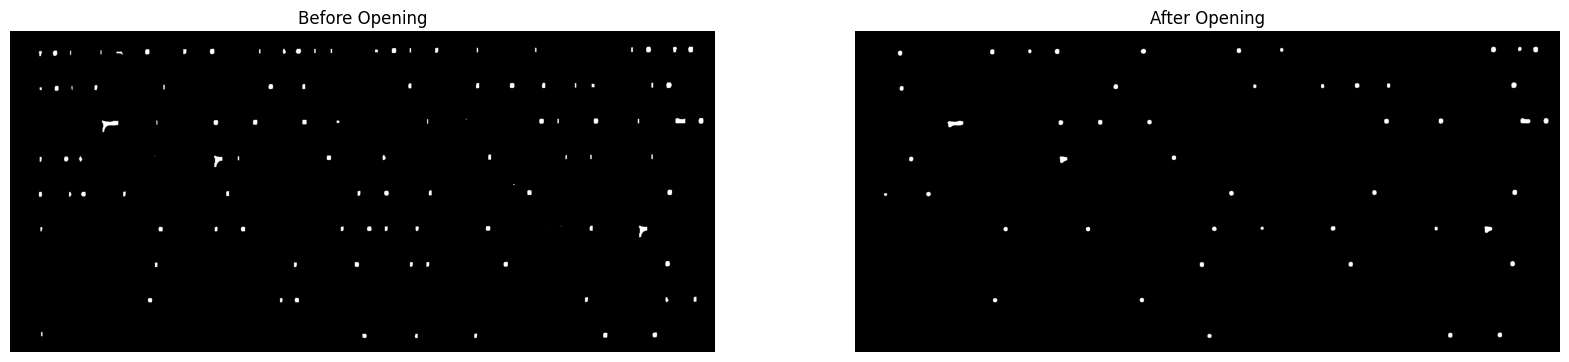

In [17]:
kernel_size = 9
se = cv2.getStructuringElement(shape =cv2.MORPH_ELLIPSE, ksize=(kernel_size, kernel_size))
imgM3_erode = cv2.erode(imgM2_erode.copy(), se)
imgM3_dilate = cv2.dilate(imgM3_erode.copy(), se)
titles = ['Before Opening', 'After Opening']
imgs = [imgM2_erode, imgM3_dilate]
plot_images(imgs, titles, 1, 2)

Iteration:  21


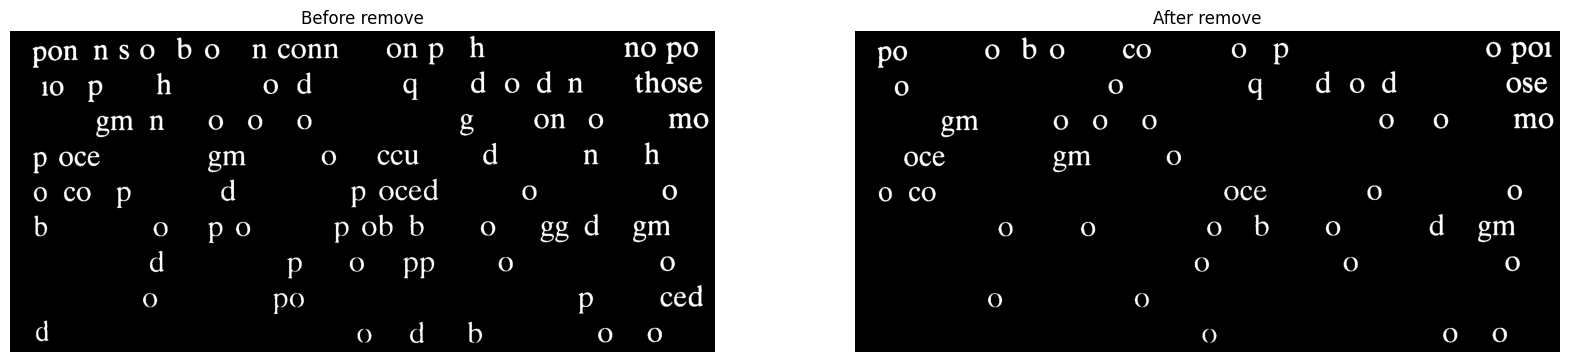

In [18]:
imgM3_reconstruct , his = img_reconstruct(imgnb, imgM3_dilate, 13)
titles = ['Before remove', 'After remove']
imgs = [imgM2_reconstruct, imgM3_reconstruct]
plot_images(imgs, titles, 1, 2)

In [19]:
img = imgM3_reconstruct.copy()

โดยผลลัพท์ที่ได้จะเป็นรูปภาพที่มีตัวอักษรที่ไม่มีลักษณะคล้ายทรงกลมถูกลบออกไปแล้วแต่จะยังมีตัวอักษรที่มีขนาดเกิน 1 บรรทัดหรือเป็นเส้นตรงยาวอยู่บนรูปภาพ

### **Second Iteration**

จะทำการลบตัวอักษรที่เป็นเส้นตรงด้วย kernel สี่เหลี่ยมผืนผ้าขนาด 1x40 

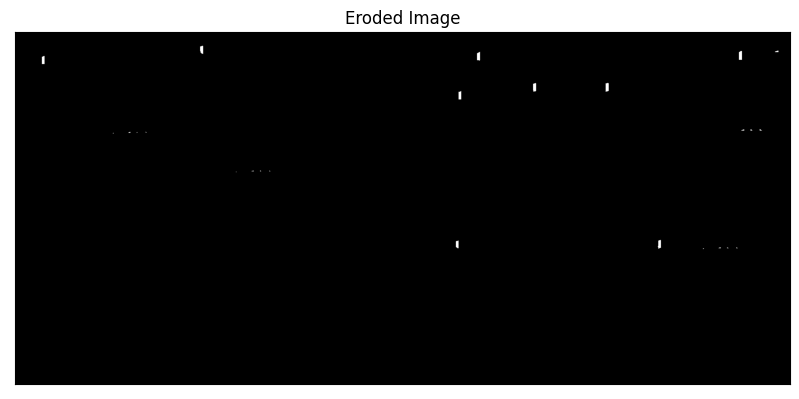

In [20]:
se = cv2.getStructuringElement(shape =cv2.MORPH_RECT, ksize=(1, 40))
imgM4_erode = cv2.erode(img.copy(), se)
show_image(imgM4_erode, 'Eroded Image')

Iteration:  14


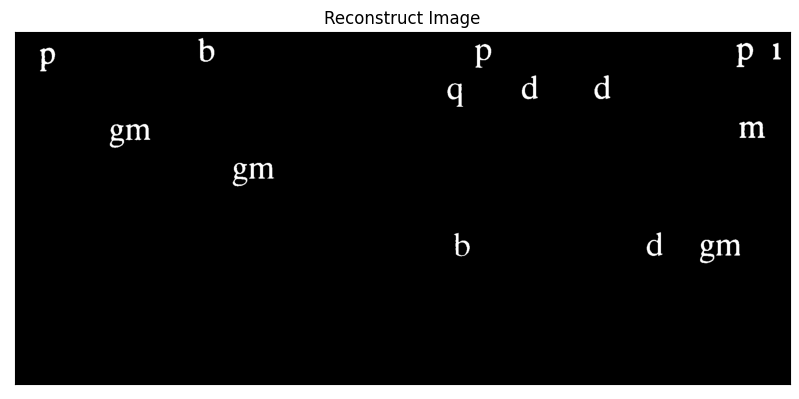

In [21]:
imgM4_reconstruct , his = img_reconstruct(img, imgM4_erode, 8)
show_image(imgM4_reconstruct, 'Reconstruct Image')

### **Subtracting**

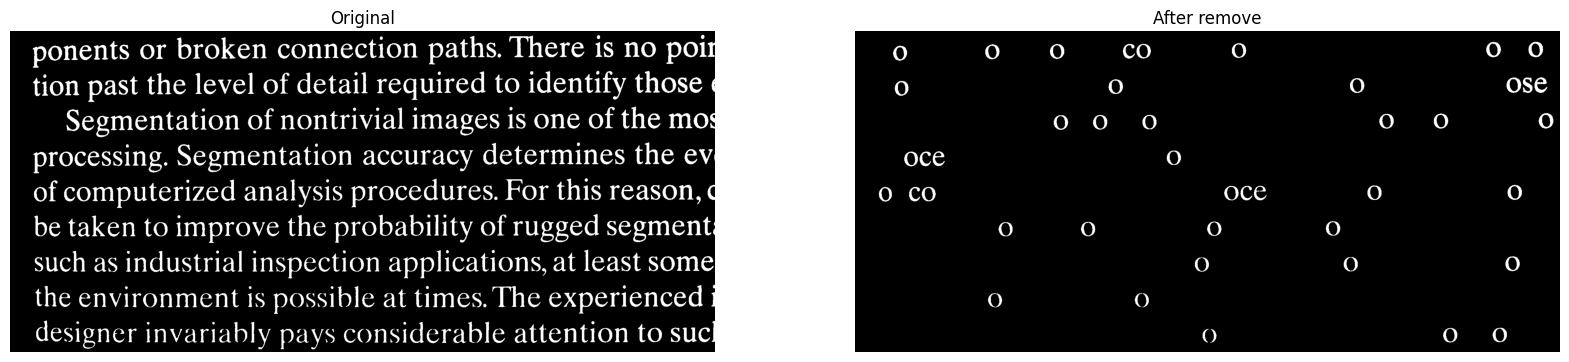

In [22]:
img_sub = cv2.subtract(img, imgM4_reconstruct)
titles = ['Original', 'After remove']
imgs = [imgOri, img_sub]
plot_images(imgs, titles, 1, 2)

## **Morphological for remove c,e,s**

เนื่องจากยังเหลือตัวอักษร c,e,s อยู่ในรูปภาพ จึงต้องทำการลบออกด้วยการใช้ Morphological อีกครั้ง

In [23]:
img = img_sub.copy()
se = cv2.getStructuringElement(shape =cv2.MORPH_RECT, ksize=(18, 4))
print(se)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


โดยรอบนี้จะ kernel รูปร่างสีเหลี่ยมผืนผ้า(ขนาด 18x4 ที่ได้จากการปรับจูน) ในการจับลักษณะของเส้นในตัวอักษร c(ขอบบนหรือขอบล่าง), e(ตรงกลาง), s(ขอบบนหรือขอบล่าง) 

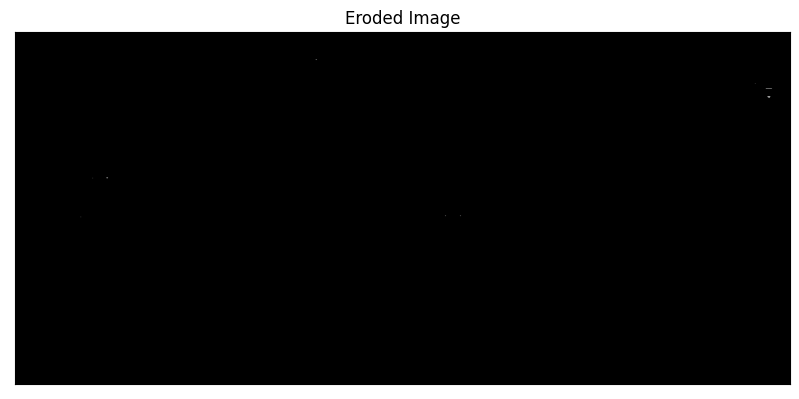

In [24]:
imgM5_erode = cv2.erode(img.copy(), se)
show_image(imgM5_erode, 'Eroded Image')

Iteration:  19


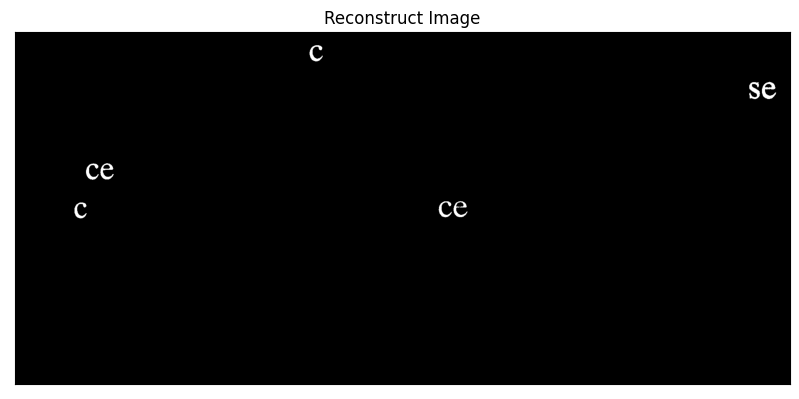

In [25]:
imgM5_reconstruct , his = img_reconstruct(img, imgM5_erode, 8)
show_image(imgM5_reconstruct, 'Reconstruct Image')

จากนั้นก็ทำการลบตัวอักษรที่เหลือออกจากรูปภาพ

## **Result**

โดยสรุปในการทำงาน Task นี้จะเป็นการค่อย ๆ ปรับจูน Kernel ให้มีขนาดตรงกับตัวอักษรที่ต้องการลบไปเรื่อย ๆ รวมถึงการใช้ Opening กับรูปที่ erode แล้วจนได้ผลลัพธ์ที่ต้องการ

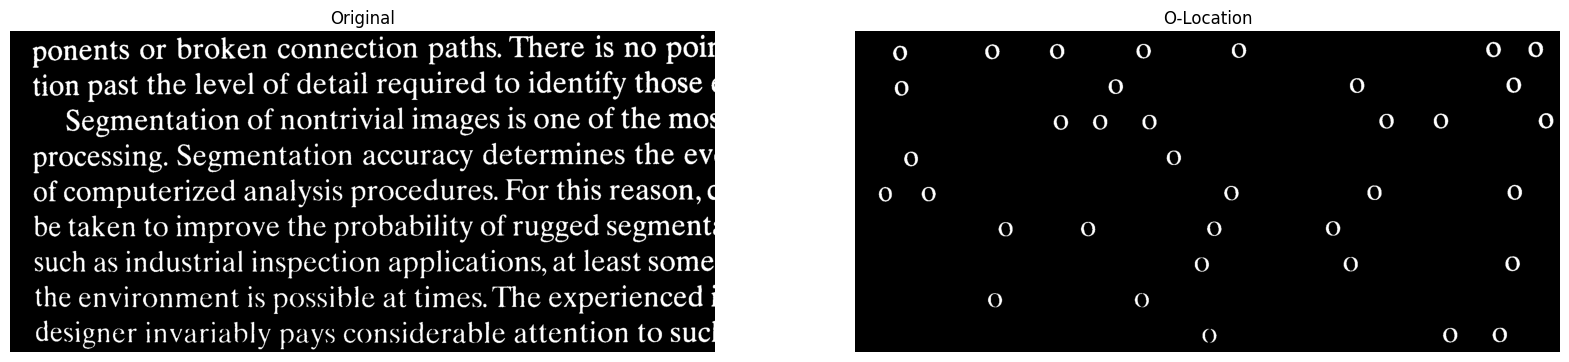

In [26]:
img_final = cv2.subtract(img, imgM5_reconstruct)
titles = ['Original', 'O-Location']
imgs = [imgOri, img_final]
plot_images(imgs, titles, 1, 2)